In [1]:
import os
import json
from collections import deque
from typing import Dict, List, Optional, Any, Union

from langchain_openai import ChatOpenAI


# Get human objective
# refine it via human in the loop and via adding context (short/long term memory search) -> the output is a json dict of the design
# build the modules and test benches usiiing short and long term memory

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["SERPAPI_API_KEY"] = os.getenv("SERPAPI_API_KEY")

In [3]:
llm = ChatOpenAI(model='gpt-3.5-turbo-0125', temperature=0)
bigllm = ChatOpenAI(model='gpt-4-0125-preview', temperature=0)

# Context for FFT

In [4]:
from bs4 import BeautifulSoup as Soup
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

# FFT docs 
url = """https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm""" #"""https://www.fpga4student.com/2017/04/verilog-code-for-16-bit-risc-processor.html"""
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Add 
#docs.extend([*docs_pydantic, *docs_sq])

# Sort the list based on the URLs in 'metadata' -> 'source'
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenate the 'page_content' of each sorted dictionary
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)

In [5]:
len(concatenated_content)

34379

# Requirement extraction chain

In [5]:
from FPGA_AGI.chains import RequirementChain

requirement_chain = RequirementChain.from_llm(bigllm)

requirements = requirement_chain.invoke(
    {"objective": "design a 32 bit 16-point FFT to run on an ultra-96 v2 FPGA board. the language must be system verilog.", #"design an 8-bit RISC V processor in system verilog", 
     "context" : concatenated_content}
)

type(requirements)

FPGA_AGI.chains.Requirements

In [6]:
import pprint
pprint.pprint(requirements.goals)
requirements.requirements = requirements.requirements[:4]
pprint.pprint(requirements.requirements)

['Design a 32-bit 16-point FFT module.',
 'Ensure compatibility with Ultra-96 V2 FPGA board.',
 'Implement the design using SystemVerilog.',
 'Optimize the design for the Cooley–Tukey FFT algorithm, specifically the '
 'radix-2 DIT case.']
['The FFT module must support 32-bit wide data inputs and outputs.',
 'The design must specifically implement a 16-point FFT, suitable for '
 'processing 16 samples per operation.',
 'The implementation must be based on the Cooley–Tukey FFT algorithm, '
 'utilizing the radix-2 DIT approach for optimization.',
 'The design must include data reordering (bit reversal) as part of the FFT '
 'computation process, ensuring the output data is in the correct order.']


# Research Agent

In [8]:
# retriever

from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader("https://www.jot.fm/issues/issue_2009_07/column2.pdf", extract_images=True) #"https://riscv.org/wp-content/uploads/2017/05/riscv-spec-v2.2.pdf"
pages = loader.load()

In [9]:
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings

embeddings_3_small = OpenAIEmbeddings(model='text-embedding-3-small')
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
texts = text_splitter.split_documents(pages)
pdfsearch = Chroma.from_documents(texts, embeddings_3_small, collection_name= "knowledge_base", persist_directory="./knowledge_base")

In [37]:
from FPGA_AGI import agents
import importlib
importlib.reload(agents)
from FPGA_AGI.agents import Researcher
from langchain_core.prompts import HumanMessagePromptTemplate

bigllm = ChatOpenAI(model='gpt-4-0125-preview', temperature=0)
R = Researcher(model=bigllm, retriever=pdfsearch.as_retriever(search_kwargs={"k": 5}))
R.stream(goals=requirements.goals, requirements=requirements.requirements, input_context= concatenated_content)
#result = R.planner_agent.invoke({'goals':requirements.goals, 'requirements':requirements.requirements, 'input_context': concatenated_content})

[HumanMessage(content='You are planning the procedure for the following. Your goal is to collect all the data and perform all the computation necessary for another hardware engineer to build the design seamlessly.\n                    goals:\n                    [\'Design a 32-bit 16-point FFT module.\', \'Ensure compatibility with Ultra-96 V2 FPGA board.\', \'Implement the design using SystemVerilog.\', \'Optimize the design for speed and resource utilization.\', \'Utilize the Cooley–Tukey FFT algorithm, specifically the radix-2 DIT variant.\']\n                    requirements:\n                    [\'The FFT module must support 32-bit wide complex number inputs and outputs.\', \'The design must be capable of processing 16 data points per FFT operation.\', \'The implementation must strictly use SystemVerilog HDL.\', \'The design should be optimized for the Xilinx Zynq UltraScale+ MPSoC architecture, considering the Ultra-96 V2 FPGA board specifications.\']\n                    user i

In [27]:
from pprint import pprint
pprint(result[0].steps)

['search: Review the Xilinx Zynq UltraScale+ MPSoC architecture specifications '
 'and the Ultra-96 V2 FPGA board capabilities to ensure compatibility and '
 'optimization opportunities.',
 'search: Study the Cooley–Tukey FFT algorithm, specifically the radix-2 DIT '
 'variant, to understand its implementation and optimization techniques.',
 'search: Gather information on best practices for implementing FFT algorithms '
 'in SystemVerilog, focusing on speed and resource utilization optimization.',
 'compute: Develop the mathematical model and compute the necessary '
 'parameters, such as twiddle factors, for the 16-point FFT based on the '
 'radix-2 DIT variant.',
 'compute: Design the data flow and control logic for the FFT module, ensuring '
 'efficient handling of 32-bit wide complex number inputs and outputs.',
 'solution: Write the final design in the form of an HDL/HLS code, adhering '
 'strictly to SystemVerilog syntax and semantics, optimized for the Xilinx '
 'Zynq UltraScale+

In [ ]:
response = R.research_agent.invoke({"messages": human_message})

In [ ]:
response[0].decision

'compute'

In [ ]:
test = []
for i in range(20):
    response = R.research_agent.invoke({"messages": human_message})
    test.append(response)

In [ ]:
test

[[decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='solution', search='NA', compute='NA')],
 [decision(decision='sol

# Compute Agent

In [ ]:
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, FunctionMessage
from langchain.prompts import PromptTemplate, MessagesPlaceholder, ChatPromptTemplate
from FPGA_AGI.tools import python_run
from langchain.agents import AgentExecutor, create_openai_tools_agent
messages = [HumanMessage(content = "compute the twiddle factors of 64 point FFT", name="Researcher")]
#response = R.compute_agent.invoke({"messages": messages})

#compute_llm_with_tool = bigllm.bind(
#    tools=[python_run],
#    tool_choice={"type": "function", "function": {"name": "python_run"}},
#)

## Prompt
#compute_prompt = ChatPromptTemplate.from_messages(
#    [(
#            "system","""
#            You are a hardware engineer helping a senior hardware engineer with their computational needs. In order to do that you use python."""
#        ),
#        MessagesPlaceholder(variable_name="messages"),
#    ]
#)
## Chain
#compute_agent = compute_prompt | compute_llm_with_tool | JsonOutputFunctionsParser()


system_prompt = """You are a hardware engineer helping a senior hardware engineer with their computational needs. In order to do that you use python.
Work autonomously according to your specialty, using the tools available to you.
You must write a code to compute what is asked of you in python to answer the question.
Do not answer based on your own knowledge/memory. instead write a python code that computes the answer, run it, and observe the results.
You must print the results in your response no matter how long or large they might be. 
You must completely print the results. Do not leave any place holders. Do not use ... 
Do not ask for clarification. You also do not refuse to answer the question.
Your other team members (and other teams) will collaborate with you with their own specialties."""
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            system_prompt,
        ),
        MessagesPlaceholder(variable_name="messages"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)
agent = create_openai_tools_agent(bigllm, [python_run], prompt)
executor = AgentExecutor(agent=agent, tools=[python_run])

In [ ]:
#compute_agent.invoke({"messages": messages})
#python_run
response = executor.invoke({"messages": messages})

In [ ]:
response['output']

'W0: (1+0j)\nW1: (0.9987954562051724-0.049067674327418015j)\nW2: (0.9951847266721969-0.0980171403295606j)\nW3: (0.989176509964781-0.14673047445536175j)\nW4: (0.9807852804032304-0.19509032201612825j)\nW5: (0.970031253194544-0.24298017990326387j)\nW6: (0.9569403357322088-0.29028467725446233j)\nW7: (0.9415440651830208-0.33688985339222005j)\nW8: (0.9238795325112867-0.3826834323650898j)\nW9: (0.9039892931234433-0.4275550934302821j)\nW10: (0.881921264348355-0.47139673682599764j)\nW11: (0.8577286100002721-0.5141027441932217j)\nW12: (0.8314696123025452-0.5555702330196022j)\nW13: (0.8032075314806449-0.5956993044924334j)\nW14: (0.773010453362737-0.6343932841636455j)\nW15: (0.7409511253549591-0.6715589548470183j)\nW16: (0.7071067811865476-0.7071067811865475j)\nW17: (0.6715589548470183-0.7409511253549591j)\nW18: (0.6343932841636455-0.773010453362737j)\nW19: (0.5956993044924334-0.8032075314806449j)\nW20: (0.5555702330196022-0.8314696123025452j)\nW21: (0.5141027441932217-0.8577286100002721j)\nW22: (

# Modular design agent

In [12]:
from FPGA_AGI.tools import search_web, python_run, Thought
from FPGA_AGI.prompts import hierarchical_agent_prompt_human
from FPGA_AGI import agents
import importlib
importlib.reload(agents)
from FPGA_AGI.agents import HierarchicalDesignAgent

#gpt-4-0125-preview gpt-4-1106-preview
model = ChatOpenAI(model='gpt-4-0125-preview', temperature=0, streaming=True)

tools = [search_web]
messages = hierarchical_agent_prompt_human.format_messages(goals=requirements.goals, requirements='\n'.join(requirements.requirements)) #.to_messages()

multiple_attempts = []

for i in range(5):
    agent = HierarchicalDesignAgent(model, tools)
    hierarchical_response = agent.invoke({'messages': messages})
    multiple_attempts.append(hierarchical_response)

Thought
search_web
Thought
Thought
Thought
search_web
Thought
Thought
Thought
search_web
Thought
Thought
Thought
Thought
search_web
Thought
Thought
Thought
search_web
Thought
search_web
Thought
Thought
Thought


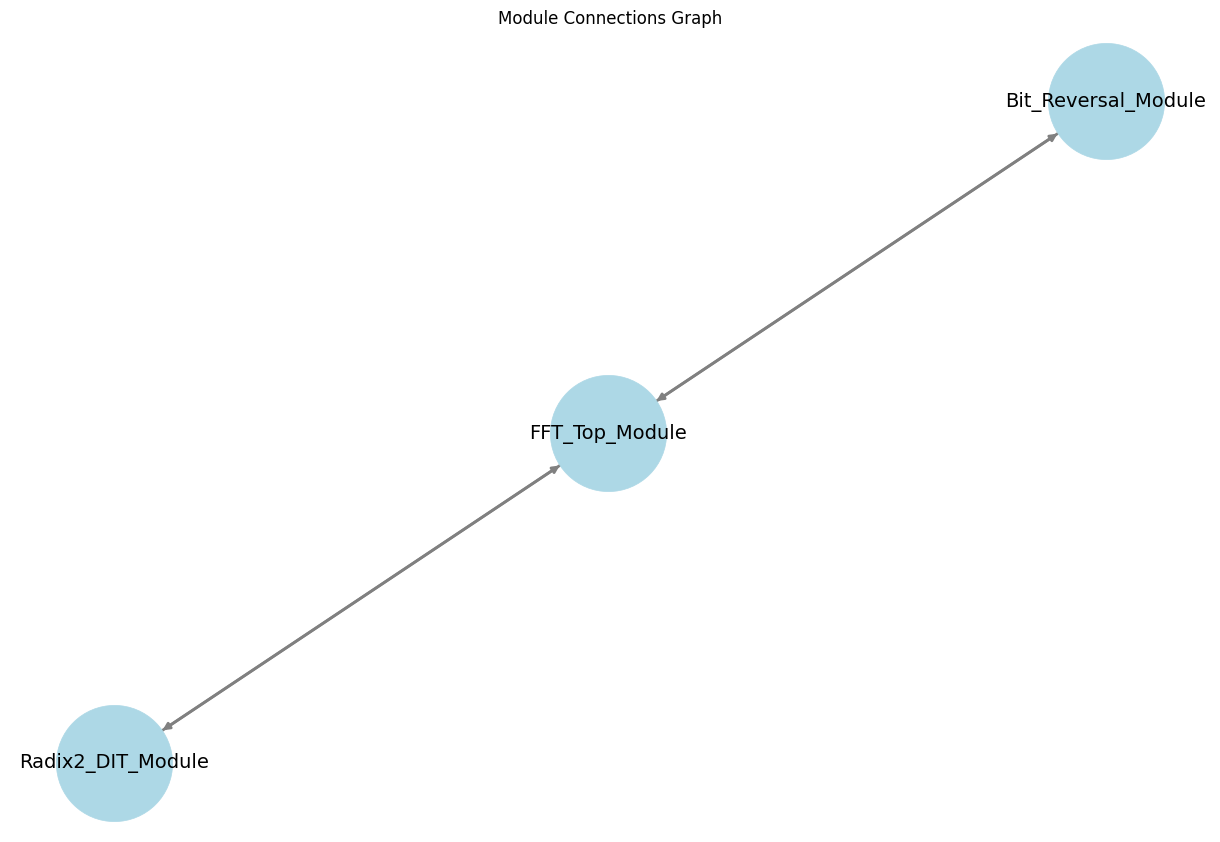

In [18]:
from FPGA_AGI.utils import plot_graph

plot_graph(hierarchicalmodules = multiple_attempts[4], save_path = None)

In [ ]:
hierarchical_response.graph

[Module(name='TopModule', description='Top-level module for the 8-bit RISC-V processor implementing the Harvard architecture.', connections=['ControlUnit', 'ALU', 'RegisterFile', 'InstructionMemory', 'DataMemory'], ports=['clk', 'reset'], notes="This module will instantiate all the submodules and wire them together according to the processor's data path and control path requirements."),
 Module(name='ControlUnit', description='Generates control signals for the processor based on the current instruction.', connections=['ALUControl', 'TopModule'], ports=['instruction[31:0]', 'control_signals'], notes='This module will decode the instruction and generate signals for the ALU, memory access, and register file operations.'),
 Module(name='ALUControl', description='Generates the ALU operation code based on the instruction opcode.', connections=['ALU', 'ControlUnit'], ports=['opcode[6:0]', 'ALU_operation'], notes='This module will decode the opcode and generate the corresponding ALU operation 

# More agents

In [ ]:
goals = 'Design an 8-bit RISC V processor using SystemVerilog.' 

requirements = '\n'.join(['1. The processor must be designed based on the RISC V instruction set and '
'should follow a Harvard-type data path structure.',
'2. Implement memory access instructions including Load Word (LD) and Store '
'Word (ST) with the specified operations.',
'3. Implement data processing instructions including Add (ADD), Subtract '
'(SUB), Invert (INV), Logical Shift Left (LSL), Logical Shift Right (LSR), '
'Bitwise AND (AND), Bitwise OR (OR), and Set on Less Than (SLT) with the '
'specified operations.',
'4. Implement control flow instructions including Branch on Equal (BEQ), '
'Branch on Not Equal (BNE), and Jump (JMP) with the specified operations.',
'5. Design the processor control unit to generate appropriate control signals '
'for each instruction type.',
'6. Design the ALU control unit to generate the correct ALU operation based '
'on the ALUOp signal and the opcode.',
'7. Implement instruction memory, data memory, register file, ALU, ALU '
'control unit, datapath unit, and control unit modules in SystemVerilog.',
'8. Ensure the processor supports a 16-bit instruction format and operates on '
'8-bit data widths.',
'9. The processor must be capable of executing the provided instruction set '
'with correct control and data flow for each instruction type.',
'10. Verify the processor design using a testbench that simulates various '
'instruction executions and validates the functionality of the processor.'])

In [ ]:
from FPGA_AGI.prompts import hierarchical_agent_prompt

hierarchical_agent_prompt.format_prompt(goals=goals, requirements=requirements).to_messages()

[SystemMessage(content='You are an FPGA design engineer whose purpose is to design the architecture graph of a HDL hardware project.\n            You are deciding on the module names, description, ports, what modules each module is connected to. You also include notes on anything that may be necessary in order for the downstream logic designers.\n            - You must expand your knowledge on the subject matter via the seach tool before committing to a response.\n            - You are not responsible for designing a test bench.\n            - If you are defining a top module or any other hierarchy, you must mention that in the module description.\n\n            Use the following format:\n\n            Thought: You should think of an action. You do this by calling the Though tool/function. This is the only way to think.\n            Action: the action to take, should be one of the functions you have access to.\n            ... (this Thought/Action can repeat 3 times)\n            Respo

# counting how many times the agent fails out of 10 repeats
failure = 0
outputs = []
for i in range(10):
    try:
        output = app.invoke(inputs)
        out = json.loads(output['messages'][-1].additional_kwargs["function_call"]["arguments"])
        outputs.append(out)
    except:
        failure += 1

print(f'Failed {failure} times out of 10 runs.')
out['graph']

from openai import OpenAI
client = OpenAI()
import json
from tqdm import tqdm

l = {}
for T in tqdm(range(0, 11)):
    response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",
    messages=[
        {
        "role": "system",
        "content": "You will be provided with a high level idea of a hardware. come up with a list of modules that such a hardware needs. only come up with a list of names."
        },
        {
        "role": "user",
        "content": "We want to build a competitor to GPU based on conventional logic. We want this new tool to beat GPUs for AI applications."
        }
    ],
    temperature=T*0.2,
    max_tokens=400,
    top_p=1
    )
    l[f'idea_{T}'] = {'T': T*0.2, 'content': response.choices[0].message.content}

out_file = open("test_gpt_3.5.json", "w") 
  
json.dump(l, out_file, indent = 6) 
  
out_file.close() 